inside if (analyze)
init analyze
[[0.0, 0.0, 18.501635193824768, 15640516.75, 17.15697106933593], [1.0, 175.0, 20.016902017593384, 15674560.65, 17.17359406738281], [2.0, 0.0, 52.300170654058455, 14386382.625, 16.544600891113284], [3.0, 175.0, 53.790374195575716, 14417909.275, 16.55999476318359], [4.0, 0.0, 74.36043018698692, 13367892.9, 16.047291455078128], [5.0, 175.0, 75.85815324187278, 13398544.1, 16.062257861328128], [6.0, 0.0, 95.5396174132824, 12399363.35, 15.574376635742189], [7.0, 175.0, 97.06121672987938, 12414361.375, 15.581699890136722], [8.0, 0.0, 108.11703817248345, 11333708.7, 15.054037451171876], [9.0, 175.0, 109.57827874422074, 11361968.875, 15.067836364746096], [10.0, 0.0, 120.21683723926544, 10385222.85, 14.590909594726563], [11.0, 175.0, 121.73323208093643, 10397409.6, 14.596860156250003], [12.0, 0.0, 134.48695697188379, 9471756.55, 14.144881127929688], [13.0, 175.0, 135.87927360534667, 9502986.0, 14.160129882812495], [14.0, 0.0, 148.74615581631662, 8611814.225, 13.7

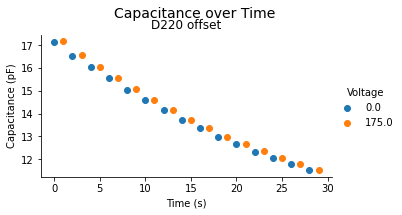

In [3]:
import serial
import math
import time
import csv
import numpy as np
import os.path
from os import path
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import seaborn
import pandas


class Shear_Distance():
    """
    Class for calculating shear distance, overlapping area, and initial
    separation distance.
    """
    def __init__(self, filename, step_size = 10, area = None, separation = None, plot = True):
        """
        Executes appropriate methods in the correct order. Takes one required
        argument which must be the name of the csv file containing the relevant
        data and several optional arguments to indicate the step size (in
        microns), the area (in mm^2) if you know it, the initial separation
        distance (in microns) if you know it, and whether you want the data
        plotted.
        """
        print("init analyze")
        self.ep = 8.85
        self.step_size = step_size
        # creates variable "self.data" that is a list of lists containing
        # all of the information from the named csv file
        self.data = self.avg_data(self.load_csv(filename))
        # creates variables "self.area" and "self.separation" which indicate
        # the error minimizing overlapping area and initial electrode
        # separation distance respectively unless values are already passed
        self.area = area
        self.separation = separation
        if area is None or separation is None:
            self.find_area_and_sep()
        # creates variable for the error minimizing shear distance by taking
        # the area and separation distance as given
        self.shear_distance = self.find_shear_distance()
        # prints the findins and plots the data
        self.print_results()
        if plot:
            self.plot_data(self.data)

    def load_csv(self, filename):
        """
        Accesses the named csv file and puts the data in a list of lists. Converts
        the str variable entries to ints and floats. The required argument is the
        filepath for the csv file being accessed.
        """
        with open(filename) as csvfile:
            data_array = list(csv.reader(csvfile))
        float_array = []
        for row in data_array:
            float_array.append(list(map(float, row)))
        return float_array

    def avg_data(self, data_array):
        """
        Groups the data by batch and averages the capacitance readings. Takes one
        argument which is a list of lists containing all of the data in the format
        its in as it is loaded in "load_csv()".
        """
        max_batch = int(int(10*float(data_array[-1][0]))/10)
        max_batch += 1
        avg_data = []
        for batch in range(max_batch):
            temp_filtered_array = []
            for row in data_array:
                if int(int(10*float(row[0]))/10) == batch:
                    temp_filtered_array.append(row)
            if temp_filtered_array != []:
                avg_data.append(np.mean(np.array(temp_filtered_array), axis = 0).tolist())
        print(avg_data)
        return avg_data


    def cap_formula(self, params):
        """
        Finds the sum of the squared errors between the experimental and
        theoretical capacitance values. Takes one required argument that is a
        list of parameters [area, separation] which are the overlapping area and
        initial separation distance.
        """
        # filters the data for only cases were the stack was NOT sheared
        zero_voltage = []
        for row in self.data:
            if row[1] == 0 and row[0]%2 == 0:
                zero_voltage.append(row)
        area, separation = params
        if self.area is not None:
            area = self.area
        if self.separation is not None:
            separation = self.separation
        # sums the squared error for each of the sheared cases
        error = 0
        for row in zero_voltage:
            # row[-1] is the experimental capacitance and row[0] is the batch
            # number which implictly tells the separation distance relative to
            # the initial separation
            error += (row[-1]-self.ep*area/(separation+self.step_size/2*row[0]))**2
        return error

    def shear(self, x):
        """
        Finds the sum of the squared errors between the experimental and
        theoretical capacitance values. Takes one required argument that is
        the shear distance of the stack.
        """
        # filters the data for only cases were the stack was sheared
        shear_voltage = []
        for row in self.data:
            if row[1] != 0:
                shear_voltage.append(row)
        # sums the squared error for each of the sheared cases
        error = 0
        for row in shear_voltage:
            error += (row[-1]-self.ep*self.area/(self.separation+x+5*(row[0]-1)))**2
        return error

    def find_area_and_sep(self):
        """
        Finds the overlapping area and initial separation distance that minimizes
        the error in experimental and theoretical capaticance values
        """
        # repeatedly runs "cap_formula" with different trial area and separation
        # to determine the minimizing case
        initial_guess = [500, 300]
        result = optimize.minimize(self.cap_formula, initial_guess)
        # once the minimum is found, the results are returned. Otherwise, there is
        # an error message
        if result.success:
            fitted_params = result.x
            # I only overwrite the area and separation if they were initially
            # not passed
            if self.area is None:
                self.area = fitted_params[0]
            if self.separation is None:
                self.separation = fitted_params[1]
            area_sep = [self.area, self.separation]
            return area_sep
        else:
            raise ValueError(result.message)

    def find_shear_distance(self):
        """
        Finds the shear distance that minimizes the error in experimental and
        theoretical capaticance values after taking the area and separation
        distance as given by the global variables.
        """
        # repeatedly runs "cap_formula" with different trial area and separation
        # to determine the minimizing case
        initial_guess = [1]
        result = optimize.minimize(self.shear, initial_guess)
        # once the minimum is found, the results are returned. Otherwise, there is
        # an error message
        if result.success:
            fitted_params = result.x
            return fitted_params[0]
        else:
            raise ValueError(result.message)

    def print_results(self):
        """
        Prints the calculated global variables of the electrodes' overlapping area,
        the intial separation distance, and the shear distance of the stack.
        """
        print(f"Area: {self.area}")
        print(f"Intitial Separation: {self.separation}")
        print(f"Shear Distance: {self.shear_distance}")

    def plot_data(self, data_array):
        """
        Plots the data as batch (x axis) vs capacitance (y axis). Required argument
        is a list of lists with batch number as the first column and capacitance as
        the last (which is the format done by collect_data.py)
        """
        print("plotting...")
        df = pandas.DataFrame({"batch":np.array(data_array)[:, 0].tolist(),
                                "Voltage":np.array(data_array)[:, 1].tolist(),
                                "time":np.array(data_array)[:, 2].tolist(),
                                "raw":np.array(data_array)[:, 3].tolist(),
                                "capacitance":np.array(data_array)[:, 4].tolist()})
        fg = seaborn.FacetGrid(data=df, hue='Voltage', aspect=1.61)
        fg.map(plt.scatter, 'batch', 'capacitance').add_legend()
        plt.suptitle("Capacitance over Time", fontsize = 14)
        plt.title("D220 offset")
        plt.xlabel("Time (s)")
        plt.ylabel("Capacitance (pF)")
        plt.subplots_adjust(top=.85)
        plt.show()

        # (ggplot(aes(x = 'time', y = 'capacitance', color = 'voltage'), data = df) +
        # geom_point())
        # plt.scatter(np.array(data_array)[:, 0].tolist(), np.array(data_array)[:, -1].tolist())
        # plt.title("Capacitance Over Time")
        # plt.show()

# def main(filename, area = None, separation = None, plot = True):
#     print("here2")
#     Shear_Distance(filename, area, separation, plot)
#
# main("csv_files/7-13_5m8.csv", plot = False)

filename = "C:/Users/SphoPM/Documents/GitHub/capacitance_sensing/csv_files/7-30_3mmshear_cal.csv"


if __name__ == "__main__":
    print("inside if (analyze)")
    Shear_Distance(filename, area = None, plot = True)
